In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np

# --- Constants ---
# Physics
RHO_WATER = 1000
G = 9.81
BUOY_MASS = 10.0
BUOY_BASE_VOLUME = 0.01
MAX_BLADDER_VOLUME = 0.002
PUMP_RATE = 0.0002

# Controller Settings
TARGET_DEPTH = 2.0
START_DEPTH = 0.5

# Simulation Settings
PRESSURE_UPDATE_RATE = 1.0  # Hz
IMU_UPDATE_RATE = 50.0      # Hz

In [2]:
class BuoyStateEstimator:
    """
    Handles state estimation using sensor fusion.
    In a real system, this class would take raw sensor data.
    Here, it takes 'true' values from the simulator and adds noise.
    """
    def __init__(self, alpha=0.98):
        # State variables
        self.depth = 0.0
        self.fused_velocity = 0.0
        
        # Sensor fusion parameter
        self.alpha = alpha  #gain for complimentary filter
        
        # Internal state for calculations
        self._last_pressure_depth = 0.0
        self._last_pressure_time = -1
        self._last_imu_time = -1

    def update_with_imu(self, true_accel_z, current_time):
        """High-frequency update using IMU's vertical acceleration."""
        if self._last_imu_time < 0:
            self._last_imu_time = current_time
            return
            
        dt = current_time - self._last_imu_time
        if dt <= 0: return

        # Add some realistic noise to the acceleration measurement
        imu_noise = np.random.normal(0, 0.05) # Noise with std dev of 0.05 m/s^2
        measured_accel_z = true_accel_z + imu_noise
        
        # Integrate acceleration to get velocity (this will drift)
        self.fused_velocity += measured_accel_z * dt
        
        # Integrate velocity to get depth (for a high-frequency estimate)
        self.depth += self.fused_velocity * dt
        
        self._last_imu_time = current_time

    def update_with_pressure(self, true_depth, current_time):
        """Low-frequency update to correct drift using the pressure sensor."""
        if self._last_pressure_time < 0:
            self._last_pressure_time = current_time
            self._last_pressure_depth = true_depth
            self.depth = true_depth # Initialize depth on first reading
            return

        dt = current_time - self._last_pressure_time
        if dt <= 0: return

        # Add some realistic noise to the pressure measurement
        pressure_noise = np.random.normal(0, 0.02) # Noise with std dev of 2cm
        measured_depth = true_depth + pressure_noise
        
        # Calculate low-frequency velocity from pressure
        velocity_from_pressure = (measured_depth - self._last_pressure_depth) / dt
        
        # --- SENSOR FUSION (Complementary Filter) ---
        # Correct the drifting IMU velocity with the stable pressure-based velocity
        self.fused_velocity = self.alpha * self.fused_velocity + (1.0 - self.alpha) * velocity_from_pressure
        
        # Also correct the depth estimate directly. This grounds our estimate in reality.
        # We can do a similar fusion for the position itself.
        self.depth = 0.9 * self.depth + 0.1 * measured_depth
        
        # Update for next iteration
        self._last_pressure_depth = measured_depth
        self._last_pressure_time = current_time

    def get_state(self):
        return self.depth, self.fused_velocity

In [3]:
class PIDController:
    """PID controller with 'Derivative on Measurement'."""
    def __init__(self, Kp, Ki, Kd, setpoint):
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.setpoint = setpoint
        
        self._integral_sum = 0.0
        self._last_time = None
        
        self.integral_min = -1.0
        self.integral_max = 1.0

    def calculate(self, process_variable, velocity, current_time):
        """
        Calculates the control signal.
        Uses velocity directly for the derivative term.
        """
        if self._last_time is None:
            self._last_time = current_time
            return 0.0
        dt = current_time - self._last_time
        if dt == 0: return 0.0

        error = self.setpoint - process_variable
        
        # Proportional term
        p_term = self.Kp * error
        
        # Integral term (with anti-windup)
        self._integral_sum += error * dt
        self._integral_sum = max(self.integral_min, min(self.integral_max, self._integral_sum))
        i_term = self.Ki * self._integral_sum
        
        # --- Derivative on Measurement ---
        # The D term now dampens motion based on actual velocity, not rate of error change.
        # This is more stable and avoids "derivative kick".
        # We use a negative sign because positive velocity (downwards) should oppose
        # a positive error (being too shallow).
        d_term = -self.Kd * velocity
        
        output = p_term + i_term + d_term
        
        self._last_time = current_time
        return output

In [4]:
class BuoySimulator:
    def __init__(self, mass, base_volume, start_depth=0.0):
        self.mass = mass
        self.base_volume = base_volume
        self.bladder_volume = 0.0
        self.depth = start_depth
        self.velocity = 0.0
        self.acceleration = 0.0
        self.neutral_bladder_volume = (self.mass / RHO_WATER) - self.base_volume
        self.bladder_volume = self.neutral_bladder_volume

    def update(self, pump_action: str, pump_duration: float, dt: float):
        if pump_action == 'inflate':
            self.bladder_volume = min(MAX_BLADDER_VOLUME, self.bladder_volume + PUMP_RATE * pump_duration)
        elif pump_action == 'deflate':
            self.bladder_volume = max(0, self.bladder_volume - PUMP_RATE * pump_duration)
        total_volume = self.base_volume + self.bladder_volume
        force_buoyant = total_volume * RHO_WATER * G
        force_gravity = self.mass * G
        force_drag = -0.5 * RHO_WATER * self.velocity * abs(self.velocity) * 1.0
        net_force = force_buoyant - force_gravity + force_drag
        self.acceleration = -net_force / self.mass
        self.velocity += self.acceleration * dt
        self.depth += self.velocity * dt
        if self.depth < 0:
            self.depth, self.velocity = 0, 0

Starting simulation with IMU and pressure sensor fusion.


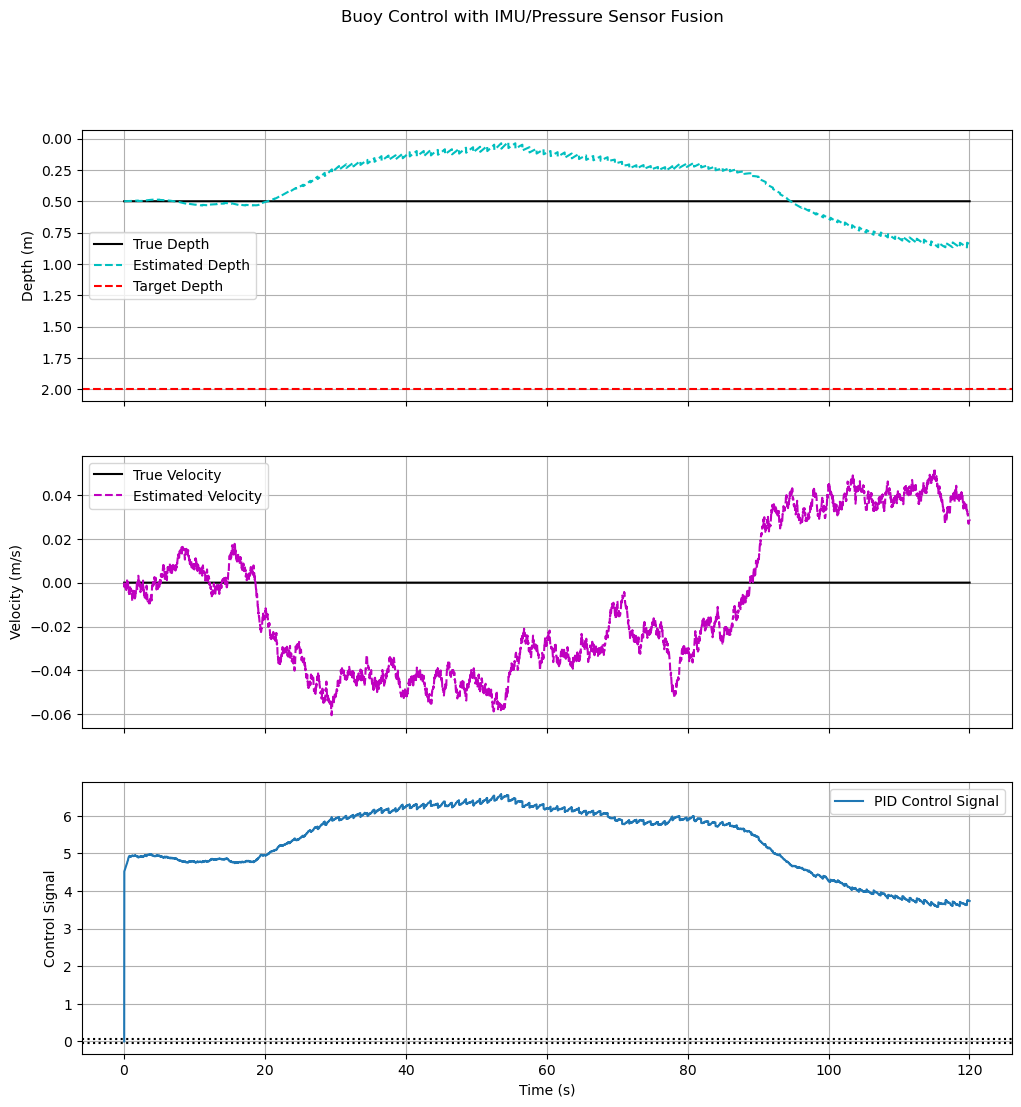

In [5]:
buoy_sim = BuoySimulator(mass=BUOY_MASS, base_volume=BUOY_BASE_VOLUME, start_depth=START_DEPTH)
estimator = BuoyStateEstimator(alpha=0.98)

# --- TUNING GAINS ---
# With a better velocity estimate, you can often use a higher Kd for better damping.
# Kp=3.0, Ki=0.4, Kd=5.0
pid = PIDController(Kp=3.0, Ki=0.4, Kd=5.0, setpoint=TARGET_DEPTH)

PUMP_TIME_SCALING_FACTOR = 0.5
MAX_PUMP_TIME = 1.0
DEADBAND = 0.05

# Simulation setup
SIM_DURATION = 120
sim_time = 0.0
dt_control = 1.0 / IMU_UPDATE_RATE

last_pressure_update_time = -1

history = {'time': [], 'true_depth': [], 'est_depth': [], 'true_vel': [], 'est_vel': [], 'signal': []}

print("Starting simulation with IMU and pressure sensor fusion.")

while sim_time < SIM_DURATION:
    sim_time += dt_control
    
    # --- SENSOR UPDATES ---
    # High-frequency IMU update
    # On a real buoy, this would be `accel = imu.read()` followed by gravity compensation
    estimator.update_with_imu(buoy_sim.acceleration, sim_time)
    
    # Low-frequency Pressure Sensor update
    if sim_time - last_pressure_update_time >= (1.0 / PRESSURE_UPDATE_RATE):
        last_pressure_update_time = sim_time
        # On a real buoy, this would be `pressure = sensor.read()`
        estimator.update_with_pressure(buoy_sim.depth, sim_time)

    # --- CONTROL LOOP (runs at high frequency) ---
    # 1. Get estimated state
    current_depth, current_velocity = estimator.get_state()
    
    # 2. Calculate control signal
    control_signal = pid.calculate(current_depth, current_velocity, sim_time)
    
    # 3. Map to pump action
    pump_action = 'none'
    pump_on_time = 0.0
    if control_signal > DEADBAND:
        pump_action = 'deflate'
        pump_on_time = min(abs(control_signal) * PUMP_TIME_SCALING_FACTOR, MAX_PUMP_TIME)
    elif control_signal < -DEADBAND:
        pump_action = 'inflate'
        pump_on_time = min(abs(control_signal) * PUMP_TIME_SCALING_FACTOR, MAX_PUMP_TIME)

    # 4. Update the physics simulation
    buoy_sim.update(pump_action, pump_on_time, dt_control)
    
    # 5. Log data for plotting
    history['time'].append(sim_time)
    history['true_depth'].append(buoy_sim.depth)
    history['est_depth'].append(current_depth)
    history['true_vel'].append(buoy_sim.velocity)
    history['est_vel'].append(current_velocity)
    history['signal'].append(control_signal)

# --- Plotting ---
fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
axs[0].plot(history['time'], history['true_depth'], 'k-', label='True Depth')
axs[0].plot(history['time'], history['est_depth'], 'c--', label='Estimated Depth')
axs[0].axhline(TARGET_DEPTH, color='r', linestyle='--', label='Target Depth')
axs[0].set_ylabel('Depth (m)'); axs[0].invert_yaxis(); axs[0].legend(); axs[0].grid(True)

axs[1].plot(history['time'], history['true_vel'], 'k-', label='True Velocity')
axs[1].plot(history['time'], history['est_vel'], 'm--', label='Estimated Velocity')
axs[1].set_ylabel('Velocity (m/s)'); axs[1].legend(); axs[1].grid(True)

axs[2].plot(history['time'], history['signal'], label='PID Control Signal')
axs[2].axhline(DEADBAND, color='k', linestyle=':'); axs[2].axhline(-DEADBAND, color='k', linestyle=':')
axs[2].set_xlabel('Time (s)'); axs[2].set_ylabel('Control Signal'); axs[2].legend(); axs[2].grid(True)

plt.suptitle('Buoy Control with IMU/Pressure Sensor Fusion')
plt.show()
